In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

from models import Autoencoder
from utils import *

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
corruption_type = "mcar"
corruption_kwargs = {"missing_rate": 0.75}

In [3]:
missingness = Missingness()

# Load the data

In [4]:
training_data, testing_data = load_mnist()

train_loader = DataLoader(training_data, batch_size=128, shuffle=True)
test_loader = DataLoader(testing_data, batch_size=128, shuffle=True)

# Train Denoising Autoencoder

In [5]:
dae = Autoencoder(input_dim=784, latent_dim=10).to(device)
optimizer = optim.Adam(dae.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

In [6]:
losses = train_autoencoder(
    model=dae,
    train_loader=train_loader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=50,
    missingness=missingness,
    corruption_type=corruption_type,
    device=device,
    **corruption_kwargs
)

Epoch 5/50: average loss = 0.0263
Epoch 10/50: average loss = 0.0224
Epoch 15/50: average loss = 0.0211
Epoch 20/50: average loss = 0.0204
Epoch 25/50: average loss = 0.0198
Epoch 30/50: average loss = 0.0195
Epoch 35/50: average loss = 0.0191
Epoch 40/50: average loss = 0.0190
Epoch 45/50: average loss = 0.0187
Epoch 50/50: average loss = 0.0185


# Plot results

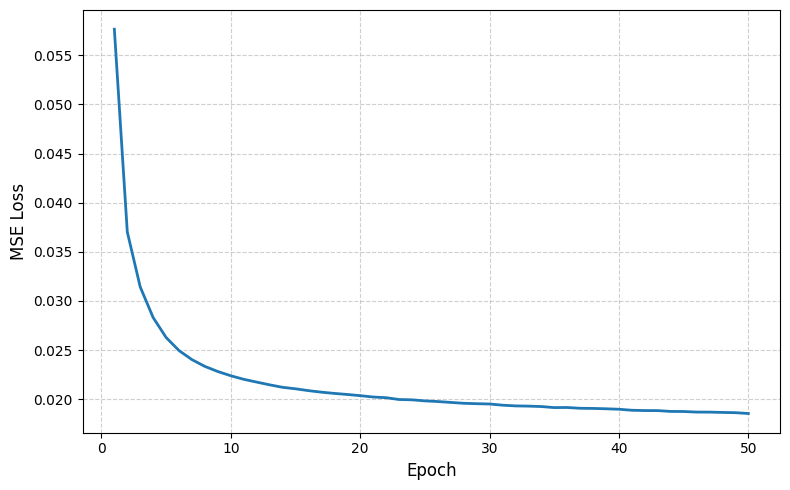

In [7]:
plot_ae_losses(losses)

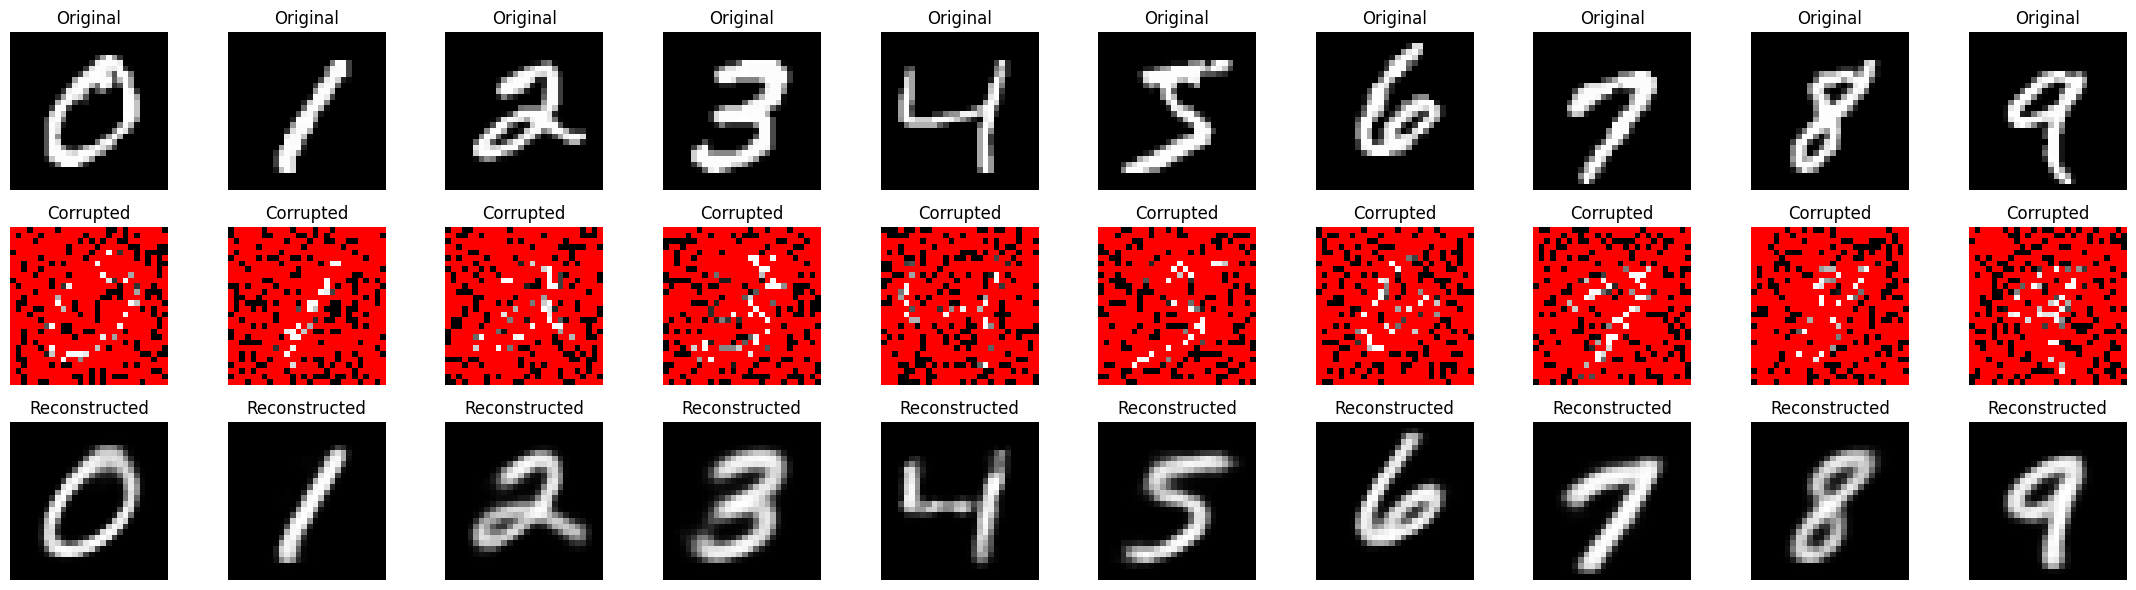

In [10]:
plot_ae_reconstructions(
    model,
    training_data,
    missingness=missingness,
    corruption_type="mcar",
    missing_rate=0.75,
    device=device,
)